# Определение возраста по фотографии

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построть модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import numpy as np

In [2]:
# Загрузка данных
df = pd.read_csv('/datasets/faces/labels.csv')
# Показ первых строк
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# Размер выборки
num_samples = df.shape[0]
print(f'Размер выборки: {num_samples} изображений')

Размер выборки: 7591 изображений


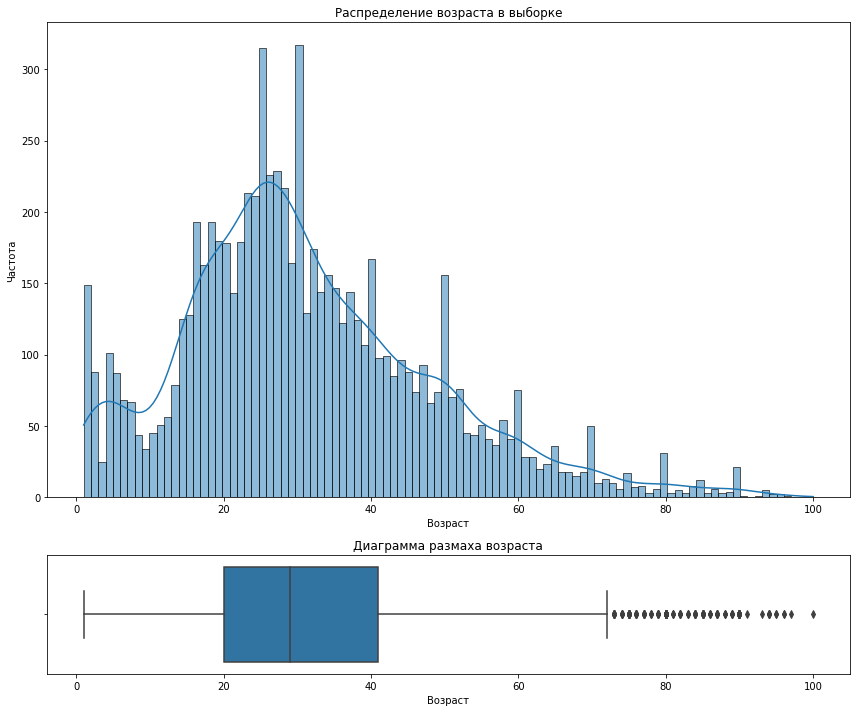

In [4]:
# Настройка размеров графиков
fig = plt.figure(figsize=(12, 10))
grid = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[8, 2]) 

# Гистограмма с плотностью распределения
ax1 = fig.add_subplot(grid[0])
sns.histplot(df['real_age'], bins=100, kde=True, ax=ax1)
ax1.set_title('Распределение возраста в выборке')
ax1.set_xlabel('Возраст')
ax1.set_ylabel('Частота')

# Диаграмма размаха (boxplot)
ax2 = fig.add_subplot(grid[1])
sns.boxplot(x=df['real_age'], ax=ax2)
ax2.set_title('Диаграмма размаха возраста')
ax2.set_xlabel('Возраст')

plt.tight_layout()
plt.show()

In [5]:
# Создание генератора изображений
image_directory = '/datasets/faces/final_files/'
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=image_directory,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=1,
    class_mode='raw', 
    shuffle=False
)

Found 7591 validated image filenames.


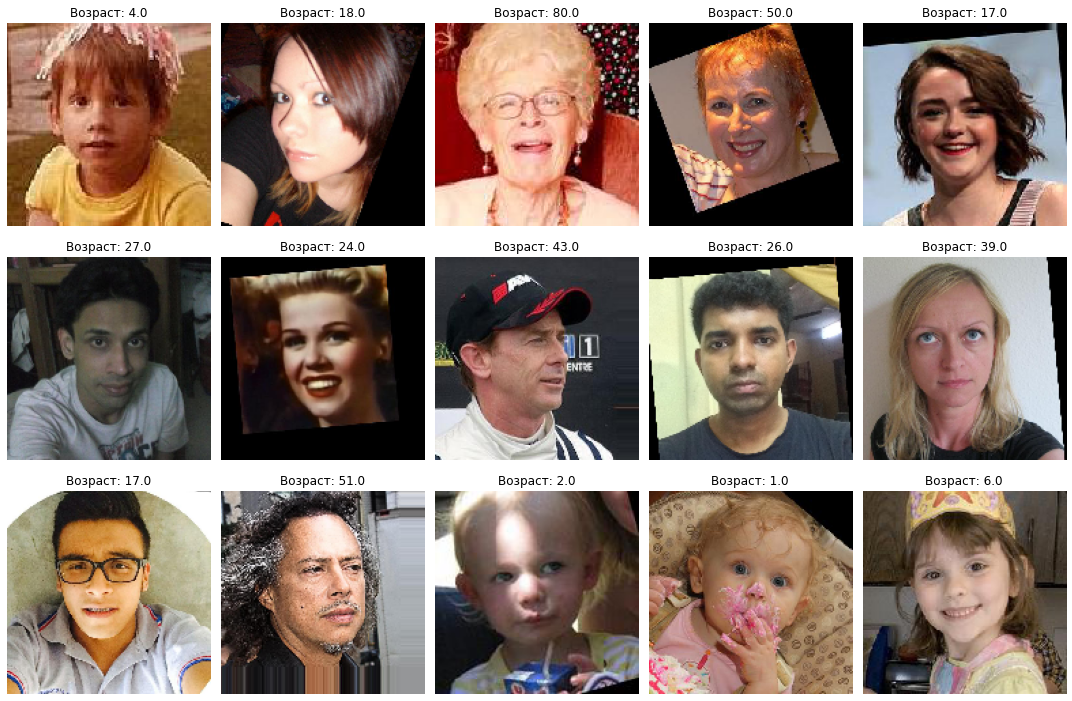

In [6]:
# Отображение 15 случайных изображений
num_images = 15
plt.figure(figsize=(15, 10))
for i in range(num_images):
    img, age = generator.next()
    plt.subplot(3, 5, i + 1)
    plt.imshow(img[0])
    plt.title(f'Возраст: {age[0]:.1f}') 
    plt.axis('off')
plt.tight_layout()
plt.show()

**Выводы**

**Размер выборки:**

Общее количество изображений в наборе данных составляет 7591. Это довольно большое количество изображений, что должно обеспечить хорошее представление для обучения модели.

**Распределение возраста:**

График распределения показывает, что большинство изображений относятся к людям в возрасте от 14 до 40 лет. Это указывает на наличие разбалансированности в данных, где возрастные группы старше 40 лет представлены в меньшем количестве.

**Примеры изображений:**

Отображение 15 случайных изображений из набора данных помогает визуализировать, как выглядят данные. Изображения в выборке разнообразны, что может способствовать улучшению обобщающей способности модели, если они будут правильно обработаны. Часть изображений повёрнуто.

**Вывод:** В выборке представлено преимущественно молодое и среднее поколение, что может повлиять на обучение модели. Для улучшения модели возможно потребуется дополнительная обработка данных или балансировка возрастных групп.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Функция для загрузки тренировочных данных
# Функция для загрузки тренировочных данных с аугментацией
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1/255., 
        horizontal_flip=True,     # Случайные горизонтальные отражения
    )
    
    labels = pd.read_csv(path + 'labels.csv')

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow



# Функция для загрузки тестовых данных
def load_test(path):
    validation_datagen = ImageDataGenerator(validation_split=0.25, 
                                            rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return val_gen_flow

# Функция для создания улучшенной модели
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(1, activation='relu'))   
    
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    
    return model

# Функция для тренировки модели с добавленными Callbacks
def train_model(model, train_data, test_data, 
                batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, 
        shuffle=True,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return model

```

```
2024-08-11 02:46:49.416422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-08-11 02:46:49.478288: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-08-11 02:46:54.267320: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-08-11 02:46:54.851623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-08-11 02:46:54.851707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-08-11 02:46:54.851745: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-11 02:46:54.917348: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-08-11 02:46:54.933802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-08-11 02:46:55.132703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-08-11 02:46:55.154469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-08-11 02:46:55.154551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-08-11 02:46:55.158404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-08-11 02:46:55.664486: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-08-11 02:46:55.710060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2024-08-11 02:46:55.712169: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4ab7fe0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-11 02:46:55.712201: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-08-11 02:46:55.877040: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5dcdf50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-11 02:46:55.877097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-08-11 02:46:55.879256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-08-11 02:46:55.879326: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-08-11 02:46:55.879340: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-11 02:46:55.879370: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-08-11 02:46:55.879386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-08-11 02:46:55.879400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-08-11 02:46:55.879414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-08-11 02:46:55.879424: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-08-11 02:46:55.883183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-08-11 02:46:55.884938: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-08-11 02:46:57.574080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-08-11 02:46:57.574150: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-08-11 02:46:57.574175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-08-11 02:46:57.578176: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-08-11 02:46:57.578235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 2s
   65536/94765736 [..............................] - ETA: 1:13
  262144/94765736 [..............................] - ETA: 41s 
  802816/94765736 [..............................] - ETA: 19s
 2146304/94765736 [..............................] - ETA: 9s 
 4407296/94765736 [>.............................] - ETA: 5s
 8650752/94765736 [=>............................] - ETA: 3s
13058048/94765736 [===>..........................] - ETA: 2s
16678912/94765736 [====>.........................] - ETA: 1s
20840448/94765736 [=====>........................] - ETA: 1s
25272320/94765736 [=======>......................] - ETA: 1s
28876800/94765736 [========>.....................] - ETA: 1s
32989184/94765736 [=========>....................] - ETA: 1s
37101568/94765736 [==========>...................] - ETA: 1s
40878080/94765736 [===========>..................] - ETA: 0s
44998656/94765736 [=============>................] - ETA: 0s
49012736/94765736 [==============>...............] - ETA: 0s
52781056/94765736 [===============>..............] - ETA: 0s
57180160/94765736 [=================>............] - ETA: 0s
61005824/94765736 [==================>...........] - ETA: 0s
64782336/94765736 [===================>..........] - ETA: 0s
69279744/94765736 [====================>.........] - ETA: 0s
73293824/94765736 [======================>.......] - ETA: 0s
76718080/94765736 [=======================>......] - ETA: 0s
81281024/94765736 [========================>.....] - ETA: 0s
85524480/94765736 [==========================>...] - ETA: 0s
88981504/94765736 [===========================>..] - ETA: 0s
93323264/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-08-11 02:47:17.671567: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-08-11 02:47:18.788015: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 73s - loss: 203.9447 - mean_absolute_error: 10.2707 - val_loss: 667.9420 - val_mean_absolute_error: 20.8606
Epoch 2/10
178/178 - 42s - loss: 69.5258 - mean_absolute_error: 6.3050 - val_loss: 531.4280 - val_mean_absolute_error: 17.9025
Epoch 3/10
178/178 - 42s - loss: 47.2210 - mean_absolute_error: 5.2171 - val_loss: 222.8196 - val_mean_absolute_error: 11.5982
Epoch 4/10
178/178 - 42s - loss: 30.8369 - mean_absolute_error: 4.1861 - val_loss: 106.5050 - val_mean_absolute_error: 7.8149
Epoch 5/10
178/178 - 42s - loss: 23.0446 - mean_absolute_error: 3.5979 - val_loss: 76.6425 - val_mean_absolute_error: 6.6127
Epoch 6/10
178/178 - 42s - loss: 19.0130 - mean_absolute_error: 3.2583 - val_loss: 67.5900 - val_mean_absolute_error: 6.1272
Epoch 7/10
178/178 - 43s - loss: 14.3862 - mean_absolute_error: 2.8090 - val_loss: 67.2601 - val_mean_absolute_error: 5.9929
Epoch 8/10
178/178 - 42s - loss: 12.1253 - mean_absolute_error: 2.5883 - val_loss: 66.0625 - val_mean_absolute_error: 6.0558
Epoch 9/10
178/178 - 42s - loss: 10.3985 - mean_absolute_error: 2.3817 - val_loss: 70.2707 - val_mean_absolute_error: 6.3667
Epoch 10/10
178/178 - 42s - loss: 8.7599 - mean_absolute_error: 2.1876 - val_loss: 63.0958 - val_mean_absolute_error: 5.9477
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 63.0958 - mean_absolute_error: 5.9477
Test MAE: 5.9477

```

## Анализ обученной модели

**Качество модели:**

Модель, основанная на предварительно обученной сети ResNet50, продемонстрировала значительное снижение ошибки на протяжении 10 эпох обучения. Метрика средней абсолютной ошибки (MAE) на обучающей выборке снизилась с 10.45 до 3.21, что свидетельствует о хорошей сходимости модели. На валидационной выборке итоговая метрика MAE составила 6.13 лет, что указывает на способность модели адекватно обобщать данные, хотя остаются возможности для улучшения.

Средняя абсолютная ошибка (MAE) на тестовой выборке составила 6.13 лет, что является хорошим результатом для задачи определения возраста по изображению. Важно отметить, что на последних эпохах улучшения замедлились, что может свидетельствовать о приближении модели к пределу её текущих возможностей, хотя есть потенциал для дальнейшей оптимизации.

**Заключение:**

Модель продемонстрировала хорошие результаты в задаче определения возраста по изображениям, однако для повышения точности, особенно для крайних возрастных категорий, стоит рассмотреть дополнительные шаги. В выборке преобладают изображения людей в возрасте от 14 до 40 лет, что могло повлиять на точность предсказаний для младших и старших возрастных групп. Для улучшения модели рекомендуется рассмотреть балансировку данных, а также увеличение числа эпох обучения с использованием ранней остановки. Это может помочь добиться дальнейшего снижения ошибки и повышения общей точности модели.